### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import base wavefront and beamline class
from wpg import Wavefront, Beamline

# import base OE wrappers
from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP

# Gaussian beam generator
from wpg.generators import build_gauss_wavefront

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT, SRWLOptCryst

#import some helpers functions
from wpg.wpg_uti_wf import propagate_wavefront, plot_t_wf, get_intensity_on_axis
from wpg.wpg_uti_oe import show_transmission

# import auxiliar functions
from Auxiliary import *

### Defining initial wavefront and writing electric field data to h5-file


*****defining initial wavefront and writing electric field data to h5-file...
calculating beam fwhm
done in 0.0s, sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.499788231945866, 27.079931842197144,2.9970290603902483
loading incident wavefront
incident wavefront doesn't exist
generating incident wavefront
saving incident wavefront
finished in 121.9s
number of meaningful slices: 18
6738.9499454584375 6744.948386056843


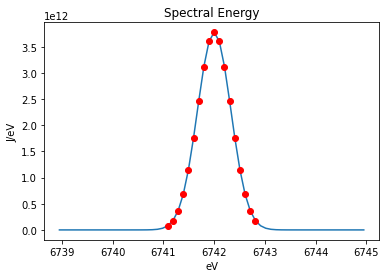

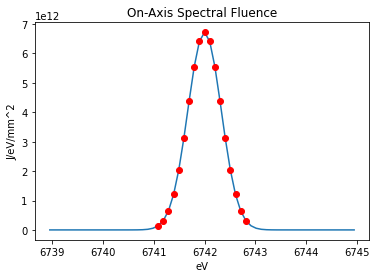

In [3]:
print('*****defining initial wavefront and writing electric field data to h5-file...')
strDataFolderName = 'WPG_output/temporal/' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

ekev = 6.742 # Energy [keV]
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
#pulse_duration = 9.e-15;
pulse_duration = 1.e-15;
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = pulse_duration

''' distance to first OE '''
z1 = 235.0
tstart = time.time()
print('calculating beam fwhm')
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('done in {}s, sigX, waist_fwhm [um], far field theta_fwhms [urad]: {}, {},{}'.format(
                            round(time.time()-tstart,2),sigX*1e6, sigX*k*1e6, theta_fwhm*1e6)
      )
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
#range_xy = range_xy*2

''' input dimensions '''
npoints=2000
pulseRange = 40
#nz = int(np.floor(pulseRange*pulse_duration/coh_time))
nz = 60

''' directories and filenames '''
dirname_duration = strDataFolderName+'{}fs_beam_nz={}_pR={}/'.format(round(pulse_duration*1e15,1),nz,pulseRange)
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
        mkdir_p(dirname_input)

fname_incident = dirname_input + 'incident_wavefront.h5'


''' load or generate '''
if_load_input = 1
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npoints, npoints, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)

print('finished in {}s'.format(round(time.time()-tstart,2)))

# input spectrum
srwl.SetRepresElecField(mwf._srwl_wf, 'f')
integral_intensity(mwf,dirname_input)
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin
print(eStart, eFin)
srwl.SetRepresElecField(mwf._srwl_wf, 't')


### 1. 1 asymmetric reflection beamline

List of optical elements:

    - asymmetric crystal at 235m from waist
    - perfect lens with 3m focal lens at 1m after crystal
    - detector at focal plane (239m from waist)

In [4]:
%autoreload 2
from Optics import *
tstart = time.time()
''' aperture '''
#Apt = Aperture('r','a',50e-6)

''' crystal parameters '''
d_sp = 3.13557135638           # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05     # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06      # imaginary part of ""
psi_hr = -2.71341902391e-05    # real part of Hth Fourier component
psi_hi = 2.50565837652e-06     # imaginary part of ""
psi_hbr = -2.71341902391e-05   # real part of -Hth Fourier component
psi_hbi = 2.50565837652e-06    # imaginary part of ""
tc = 0.01                      # crystal thickness
ang_as = -np.deg2rad(5)        # asymmetric angle
uc = 1                         # use case: 1 (Bragg reflection); 2 (Bragg transmission)
#ang = 0.83257236543
#amp_coef = 1.0

OE_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' crystal orientation '''
ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# outward normal vector to crystal surface
nvx, nvy, nvz = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]

# central tangential vector
tvx, tvy, _ = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][0]

OE_Crystal.set_orient(nvx,nvy,nvz,tvx,tvy)

''' lens parameter '''
n = 1 - 5.89e-6           # material refractive index
d_abs = 788e-6        # material absorption depth

nx = 2000
ny = 2000
Lens_width = 5e-3
f_lens = 3.0

print('calculating OPD and transmission')
Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(nx,ny,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=eStart,_eFin=eFin)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,nx)
Lens_y = np.linspace(-Lens_width/2,Lens_width/2,ny)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_y)

Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)

Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

print('done in {}s'.format(round(time.time()-tstart,2)))

calculating OPD and transmission
done in 7.05s


### 1. 2 propagation of reflected beam


In [5]:
''' Propagation distance '''
z2 = 1
z3 = f_lens

dirname_prop = dirname_duration+'propagation_{}m/'.format(z2)
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' temporal slices for 3D beam '''
nslice_t = 5
delta_t = 2e-3     # temporal slice spacing [m]
z3_list = (np.arange(nslice_t)-(nslice_t-1)/2)*delta_t + z3
print('distances: '+ str(z3_list))

''' reflected beam '''
# bl for asymmetric reflection
print('defining asymmetric reflection beamline')
optBL0 = Beamline()
optBL0.append(OE_Crystal, Use_PP(semi_analytical_treatment=0))
optBL0.append(Drift(z2),  Use_PP(semi_analytical_treatment=0))

# initialize reflected wavefront
mwf_reflected = Wavefront()
mwf_reflected.load_hdf5(fname_incident)

# propagate beam
startTime = time.time()
print('propagating reflected beam')
srwl.SetRepresElecField(mwf_reflected._srwl_wf, 'f') # <---- switch to frequency domain
optBL0.propagate(mwf_reflected)
srwl.SetRepresElecField(mwf_reflected._srwl_wf, 't')
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

# save reflected field
tstart = time.time()
fname_reflected = dirname_prop + 'reflected_wavefront.h5'
mwf_reflected.store_hdf5(fname_reflected)
print('reflected wavefront saved in {}s'.format(round(time.time()-tstart,2)))



distances: [2.996 2.998 3.    3.002 3.004]
defining asymmetric reflection beamline
propagating reflected beam
propagation lasted: 1.5 min
reflected wavefront saved in 107.95s


### 1. 3 propagation of first slice of focused beam


In [6]:
''' focused beam '''
# bl for focusing to the first temporal slice
print('defining focusing beamline')
optBL1 = Beamline()
#optBL1.append(OE_Crystal, Use_PP(semi_analytical_treatment=0))
#optBL1.append(Drift(z2),  Use_PP(semi_analytical_treatment=0))
optBL1.append(Lens_Apt,   Use_PP(semi_analytical_treatment=0))
optBL1.append(Lens_Tr,    Use_PP(semi_analytical_treatment=0))
optBL1.append(Drift(z3_list[0]),  Use_PP(semi_analytical_treatment=0))

# bl for propagation between temporal slices
optBL2 = Beamline()
optBL2.append(Drift(delta_t),  Use_PP(semi_analytical_treatment=0))

# initialize focused wavefront
mwf_focused = Wavefront()
mwf_focused.load_hdf5(fname_reflected)

# propagate beam
startTime = time.time()
print('propagating first tslice of focused beam')
srwl.SetRepresElecField(mwf_focused._srwl_wf, 'f') # <---- switch to frequency domain
optBL1.propagate(mwf_focused)
srwl.SetRepresElecField(mwf_focused._srwl_wf, 't')

print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

# save focused field
tstart = time.time()
fname_focused = dirname_prop+'focuesd_wavefront_slice_0.h5'
mwf_focused.store_hdf5(fname_focused)
print('first slice of focused wavefront saved in {}s'.format(round(time.time()-tstart,2)))



defining focusing beamline
propagating first tslice of focused beam
propagation lasted: 1.0 min
first slice of focused wavefront saved in 106.52s


### 1. 4 propagation of temporal slices

In [7]:
''' propagate temporal slices '''
img_holder = np.zeros((nslice_t,npoints,npoints))
lim_holder = np.zeros((nslice_t,4))
tstart = time.time()
print('propagating between tslices of focused beam and plotting integrated intensity')
for islice in range(nslice_t):
    mwf_focused = Wavefront()
    if islice == 0:
        mwf_focused.load_hdf5(fname_focused)
    else:
        mwf_focused.load_hdf5(fname_focused)
        srwl.SetRepresElecField(mwf_focused._srwl_wf, 'f')
        optBL2.propagate(mwf_focused)
        srwl.SetRepresElecField(mwf_focused._srwl_wf, 't')
        fname_focused = dirname_prop+'focuesd_wavefront_slice_'+str(islice)+'.h5'
        mwf_focused.store_hdf5(fname_focused)
    print(fname_focused)
    img_holder[islice] = mwf_focused.get_intensity().sum(axis=-1)
    lim_holder[islice] = mwf_focused.get_limits()
print('done')
print('propagation lasted: {}s'.format(round(time.time() - tstart),2))

propagating between tslices of focused beam and plotting integrated intensity
WPG_output/temporal/1.0fs_beam_nz=60_pR=40/propagation_1m/focuesd_wavefront_slice_0.h5
R-space
WPG_output/temporal/1.0fs_beam_nz=60_pR=40/propagation_1m/focuesd_wavefront_slice_1.h5
R-space
WPG_output/temporal/1.0fs_beam_nz=60_pR=40/propagation_1m/focuesd_wavefront_slice_2.h5
R-space
WPG_output/temporal/1.0fs_beam_nz=60_pR=40/propagation_1m/focuesd_wavefront_slice_3.h5
R-space
WPG_output/temporal/1.0fs_beam_nz=60_pR=40/propagation_1m/focuesd_wavefront_slice_4.h5
R-space
done
propagation lasted: 786s


In [8]:
''' plot temporal slices '''
dirname_tslice = dirname_prop+'tslices/'
if not os.path.exists(dirname_tslice):
    mkdir_p(dirname_tslice)

cmin = np.min(img_holder)
cmax = np.max(img_holder)
plt.figure()
for islice in range(nslice_t):
    img = img_holder[islice]
    lim = lim_holder[islice]
    # plot integrated intensity
    [xmin, xmax, ymin, ymax] = lim
    d_fov = 200e-6
    range_max = np.min(np.abs([xmax-xmin, ymax-ymin]))
    if d_fov>= range_max:
        d_fov == range_max

    roi_ratio_x = np.abs(d_fov/(xmax-xmin))
    roi_ratio_y = np.abs(d_fov/(ymax-ymin))
    roixi = int(nx*(1-roi_ratio_x)/2); roixf = int(nx*(1+roi_ratio_x)/2)
    roiyi = int(ny*(1-roi_ratio_y)/2); roiyf = int(ny*(1+roi_ratio_y)/2)

    xlimi = xmin*roi_ratio_x; xlimf = xmax*roi_ratio_x
    ylimi = ymin*roi_ratio_y; ylimf = ymax*roi_ratio_y

    print('plotting focused beam')
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.imshow(img[roixi:roixf,roiyi:roiyf], cmap='jet', clim=[cmin,cmax],
              extent = [xlimi*1e6, xlimf*1e6, ylimi*1e6, ylimf*1e6])
    plt.colorbar()
    plt.title('focused beam',fontsize=18)
    plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)

    plt.subplot(1,2,2)
    plt.imshow(np.log(img)[roixi:roixf,roiyi:roiyf], cmap='jet',clim=[np.log(cmin),np.log(cmax)],
              extent = [xlimi*1e6, xlimf*1e6, ylimi*1e6, ylimf*1e6])
    plt.colorbar()
    plt.title('log, z={}, f={}'.format(z3_list[islice],z3),fontsize=18)
    plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)
    plt.savefig(dirname_tslice+'tslice_{}.png'.format(islice),transparent = True)
    plt.clf()
plt.close('all')
print('plots saved')

plotting focused beam
plotting focused beam
plotting focused beam
plotting focused beam
plotting focused beam
plots saved


number of meaningful slices: 16


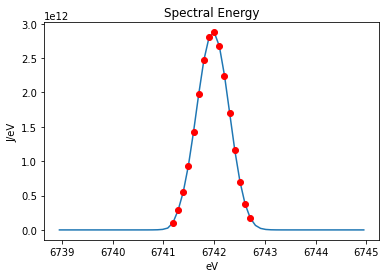

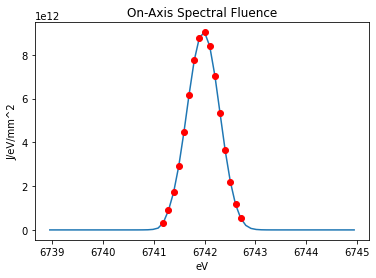

In [9]:
import imageio
t = round(pulse_duration*1e15,1)
dirname_temp = "WPG_output/temporal/"+str(t)+'fs_beam_nz='+str(nz)+'_pR='+str(pulseRange)+'/propagation_1m/'
# make gif
with imageio.get_writer(dirname_temp+'tslices/beam.gif', mode='I', duration=0.8) as writer:
    for islice in range(nslice_t):
        filename = dirname_temp+'tslices/tslice_{}.png'.format(islice)
        image = imageio.imread(filename)
        writer.append_data(image)

# plot reflected beam spectrum
mwf_temp = Wavefront()
mwf_temp.load_hdf5(dirname_temp+'reflected_wavefront.h5')

srwl.SetRepresElecField(mwf_temp._srwl_wf, 'f')
integral_intensity(mwf_temp,dirname_temp)
srwl.SetRepresElecField(mwf_temp._srwl_wf, 't')